# Benchmark: Pandas vs NumPy vectorization

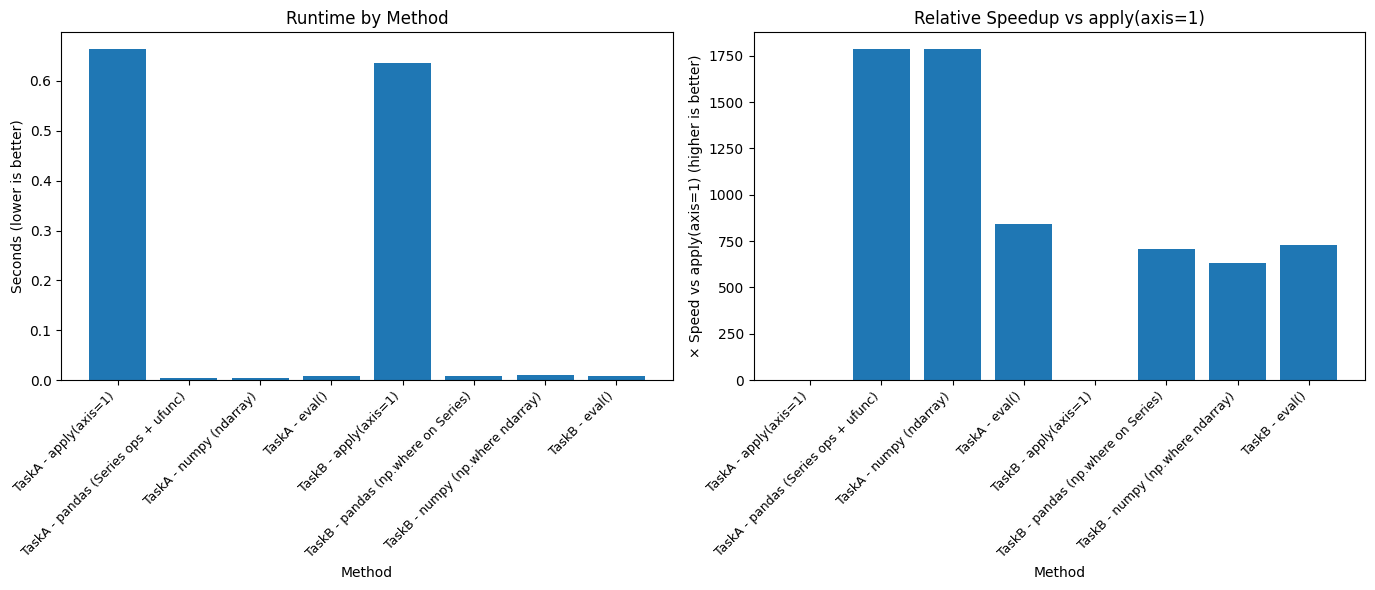

In [9]:
import numpy as np
import pandas as pd
import math, time, gc
import matplotlib.pyplot as plt

# --- Config ---
n_large = 2_000_000   # 대규모 벡터화 연산 벤치마크용 데이터 크기
n_small = 200_000     # apply(axis=1) 방식 속도 측정을 위한 소규모 데이터 크기 (시간 초과 방지)
rng = np.random.default_rng(42)  # 난수 생성기 시드 고정

# 난수 데이터프레임 생성 함수
def make_df(n):
    a = rng.random(n, dtype=np.float32)                    # 0~1 사이 난수
    b = rng.random(n, dtype=np.float32)                    # 0~1 사이 난수
    c = rng.random(n, dtype=np.float32) * 2*np.pi           # 0~2π 범위 난수
    return pd.DataFrame({'a': a, 'b': b, 'c': c})

# 대규모/소규모 데이터 생성
df_large = make_df(n_large)
df_small = df_large.iloc[:n_small].copy()

results = []  # 각 방법별 성능 결과 저장 리스트

# 실행 시간 측정 함수
def time_it(label, func, df):
    gc.collect()  # 메모리 정리
    t0 = time.perf_counter()
    out = func(df)  # 함수 실행
    t1 = time.perf_counter()
    elapsed = t1 - t0  # 실행 시간 계산
    results.append({'method': label, 'rows': len(df), 'seconds': elapsed})  # 결과 저장
    return out

# --- Task A: d = a*b + sin(c) ---
# apply(axis=1) 방식
def taskA_apply(df):
    return df.apply(lambda r: r['a']*r['b'] + math.sin(r['c']), axis=1)

# Pandas Series 연산 + NumPy ufunc 방식
def taskA_pandas(df):
    return df['a']*df['b'] + np.sin(df['c'])

# NumPy ndarray 직접 연산 방식
def taskA_numpy(df):
    a = df['a'].to_numpy()
    b = df['b'].to_numpy()
    c = df['c'].to_numpy()
    return a*b + np.sin(c)

# pandas.eval() 방식 (내부적으로 numexpr 가능 시 사용)
def taskA_eval(df):
    return df.eval("a*b + sin(c)")

# --- Task B: e = where(a>0.5, a+b, a-b) ---
# apply(axis=1) 방식
def taskB_apply(df):
    return df.apply(lambda r: (r['a']+r['b']) if (r['a']>0.5) else (r['a']-r['b']), axis=1)

# Pandas Series에 np.where 적용
def taskB_pandas(df):
    return np.where(df['a']>0.5, df['a']+df['b'], df['a']-df['b'])

# NumPy ndarray 직접 np.where 적용
def taskB_numpy(df):
    a = df['a'].to_numpy()
    b = df['b'].to_numpy()
    return np.where(a>0.5, a+b, a-b)

# pandas.eval() 방식 (조건부 연산을 불리언 마스크 연산으로 표현)
def taskB_eval(df):
    return df.eval("(a > 0.5) * (a + b) + (a <= 0.5) * (a - b)")

# --- 벤치마크 실행 ---
# Task A
_ = time_it("TaskA - apply(axis=1)", taskA_apply, df_small)
_ = time_it("TaskA - pandas (Series ops + ufunc)", taskA_pandas, df_large)
_ = time_it("TaskA - numpy (ndarray)", taskA_numpy, df_large)
_ = time_it("TaskA - eval()", taskA_eval, df_large)

# Task B
_ = time_it("TaskB - apply(axis=1)", taskB_apply, df_small)
_ = time_it("TaskB - pandas (np.where on Series)", taskB_pandas, df_large)
_ = time_it("TaskB - numpy (np.where ndarray)", taskB_numpy, df_large)
_ = time_it("TaskB - eval()", taskB_eval, df_large)

# 결과 DataFrame 생성
res_df = pd.DataFrame(results)
res_df['throughput_rows_per_sec'] = res_df['rows'] / res_df['seconds']  # 처리량 계산

# apply(axis=1) 대비 상대 속도 계산 함수
def relative_speed(row):
    task = row['method'][:5]  # "TaskA" 또는 "TaskB"
    baseline = res_df[(res_df['method'].str.startswith(task)) & (res_df['method'].str.contains('apply'))].iloc[0]
    baseline_rate = baseline['throughput_rows_per_sec']
    return row['throughput_rows_per_sec'] / baseline_rate

res_df['x_speed_vs_apply'] = res_df.apply(relative_speed, axis=1)

# --- 시각화 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 첫 번째 그래프
ax1.bar(res_df['method'], res_df['seconds'])
ax1.set_xlabel("Method")
ax1.set_ylabel("Seconds (lower is better)")
ax1.set_title("Runtime by Method")
ax1.set_xticks(range(len(res_df['method'])))
ax1.set_xticklabels(res_df['method'], rotation=45, ha='right', fontsize=9)  # 오른쪽 정렬로 맞춤

# 두 번째 그래프
ax2.bar(res_df['method'], res_df['x_speed_vs_apply'])
ax2.set_xlabel("Method")
ax2.set_ylabel("× Speed vs apply(axis=1) (higher is better)")
ax2.set_title("Relative Speedup vs apply(axis=1)")
ax2.set_xticks(range(len(res_df['method'])))
ax2.set_xticklabels(res_df['method'], rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()